In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#polynomial fit
#we use this for fitting a sell schedule

poly_day_index = np.array([0,10,20,30,40,50,60,70,80,90])
poly_hold_pct = np.array([1,0.98,0.95,0.7,0.5,0.3,0.1,0,0,0])

polynomial_parameter = np.polyfit(poly_day_index,poly_hold_pct,8)
polynomial_parameter

array([ 2.40575397e-13, -9.14157330e-11,  1.42542892e-08, -1.17354493e-06,
        5.45326287e-05, -1.40316975e-03,  1.75952885e-02, -8.17452389e-02,
        9.99975730e-01])

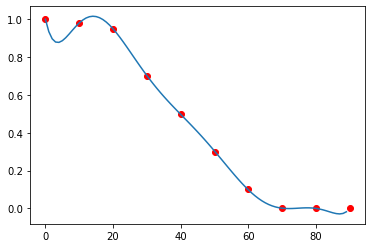

In [3]:
day_index = []
hold_pct = []
p = np.poly1d(polynomial_parameter)
for index in range(0,90):
    day_index.append(index)
    hold_pct.append(p(index))

plt.plot(day_index,hold_pct)
plt.scatter(poly_day_index,poly_hold_pct,c = 'r')
plt.show()

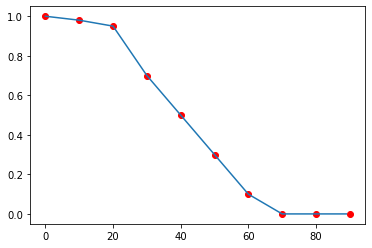

In [4]:
#piece-wise linear fit


linear_day_index = np.array([0,10,20,30,40,50,60,70,80,90])
linear_hold_pct = np.array([1,0.98,0.95,0.7,0.5,0.3,0.1,0,0,0])

day_index_plot = []
hold_pct_plot = []

for day_index in range(0,90):
    
    index = int(day_index/10)

    if index<len(linear_day_index)-1:
        piecewise_linear_x = linear_day_index[index:index+2]
        piecewise_linear_y = linear_hold_pct[index:index+2]
        

        linear_parameter = np.polyfit(piecewise_linear_x,piecewise_linear_y,1)
        p = np.poly1d(linear_parameter)
        
        day_index_plot.append(day_index)
        hold_pct_plot.append(p(day_index))

    

plt.plot(day_index_plot,hold_pct_plot)
plt.scatter(linear_day_index,linear_hold_pct,c = 'r')
plt.show()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

In [6]:
def risk_density(t):
    #assume an exponential risk increase
    a = 1/10000
    b = np.log(1/a)/90
    return np.exp(-1*a*(np.exp(b*t)-1)/b)*a*np.exp(b*t)

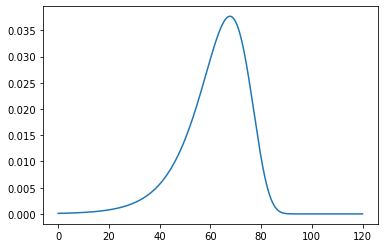

In [7]:
def plot_f_t():
    #this is f(t)
    plot_x = []
    plot_y = []
   
    for x_index in range(0,12000):
        x = x_index/100
        y = risk_density(x)
        plot_x.append(x)
        plot_y.append(y)

    return plot_x,plot_y

plot_x,plot_y = plot_f_t()
plt.plot(plot_x,plot_y)
plt.show()

In [8]:
def compute_cdf():
    cdf_x = []
    pdf_y = []
   
    for x_index in range(0,100000):
    #for x_index in range(-5000,5000):
        x = x_index/1000
        y = risk_density(x)
        cdf_x.append(x)
        pdf_y.append(y)
       
    dx = 1/1000
    cdf_y = [pdf_y[0]*dx]
    for index in range(1,len(pdf_y)):
        cdf_y.append(cdf_y[index-1]+pdf_y[index]*dx)
   
    return cdf_x,cdf_y

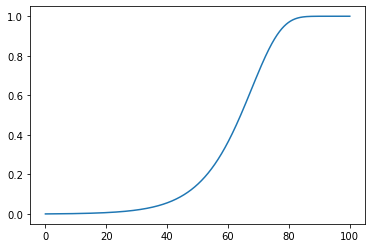

In [9]:
cdf_x,cdf_y = compute_cdf()
plt.plot(cdf_x,cdf_y)
plt.show()

In [10]:
def generate_sample():
    r = uniform.rvs(size = 1)
    index = np.argmin(np.abs(np.array(cdf_y)-r))
    return cdf_x[index]

In [11]:
#load spy data

spy_data = pd.read_csv("SPY.csv")
spy_data = spy_data.rename(columns = {"Date":"Date",\
                           "Open":"spy_open",\
                           "High":'spy_high',\
                           'Low':'spy_low',\
                           'Close':'spy_close',\
                           'Adj Close':'spy_adj_close',\
                           'Volume':'spy_volume'})

In [12]:
spy_data.tail()

,Date,spy_open,spy_high,spy_low,spy_close,spy_adj_close,spy_volume
7113,2021-04-29,420.320007,420.720001,416.440002,420.059998,420.059998,78544300
7114,2021-04-30,417.630005,418.540009,416.339996,417.299988,417.299988,85448400
7115,2021-05-03,419.429993,419.839996,417.670013,418.200012,418.200012,68128300
7116,2021-05-04,416.070007,416.600006,411.670013,415.619995,415.619995,101591200
7117,2021-05-05,417.380005,417.630005,415.149994,415.750000,415.750000,39873700


In [13]:
#most recent 2000 days

recent_daily_price = spy_data['spy_adj_close'].tolist()[-2000:]

In [14]:
daily_change = [j/i-1 for i, j in zip(recent_daily_price[:-1], recent_daily_price[1:])]

daily_change_mean = np.mean(daily_change)
print(daily_change_mean)
daily_change_std = np.std(daily_change)
print(daily_change_std)

0.0005935722491345876
0.010686090041160256


In [15]:
from scipy.stats import norm


#now, let's repeat the process 1000 times

total_data = np.zeros((0,90))
known_taper_time = []

for simulation_index in range(0,500):
   
    #create one sample
    spike_time = int(generate_sample())

    stock_prices = [100]
    
    for day_index in range(0,90-1):
        
        if day_index == spike_time:
            stock_prices.append(stock_prices[-1]*(1-0.1*3))
            known_taper_time.append(spike_time)
        elif day_index>spike_time and day_index<=spike_time+10:
            simulate_pct_change = norm.rvs(size=1,loc=daily_change_mean*-1,scale=daily_change_std)
            simulate_pct_change = simulate_pct_change[0]*3
            stock_prices.append(stock_prices[-1]*(simulate_pct_change+1))
        else:
            simulate_pct_change = norm.rvs(size=1,loc=daily_change_mean,scale=daily_change_std)
            simulate_pct_change = simulate_pct_change[0]*3
            stock_prices.append(stock_prices[-1]*(simulate_pct_change+1))

           
    #####
    total_data = np.vstack((total_data,stock_prices))

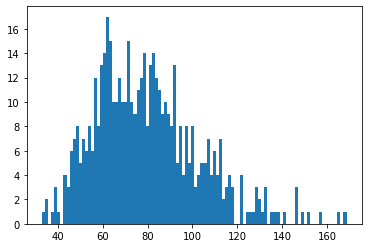

In [16]:
plt.hist(total_data[:,-1],bins = 100)
plt.show()

In [17]:
np.mean(total_data[:,-1])-np.std(total_data[:,-1])

56.36266252218637

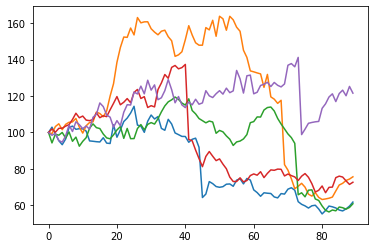

In [18]:
for index in range(0,5):
    plt.plot(total_data[index,:])
plt.show()

In [51]:
def get_window_score(q, free_parameters, total_data_index, plot_graphs=False):
    
    #current upro holding
    upro_init_quantity = 2800
    
    #obtain a sell schedule based on given free parameters
    linear_day_index = np.array([0,10,20,30,40,50,60,70,80,90])
    linear_hold_pct = np.array([free_parameters['0'],\
                                free_parameters['10'],\
                                free_parameters['20'],\
                                free_parameters['30'],\
                                free_parameters['40'],\
                                free_parameters['50'],\
                                free_parameters['60'],\
                                free_parameters['70'],\
                                free_parameters['80'],\
                                free_parameters['90']])
    day_index_interpolate = []
    hold_pct_interpolate = []
    for day_index in range(0,90):
        index = int(day_index/10)
        if index<len(linear_day_index)-1:
            piecewise_linear_x = linear_day_index[index:index+2]
            piecewise_linear_y = linear_hold_pct[index:index+2]

            linear_parameter = np.polyfit(piecewise_linear_x,piecewise_linear_y,1)
            p = np.poly1d(linear_parameter)

            day_index_interpolate.append(day_index)
            hold_pct_interpolate.append(p(day_index))
            
    
    #trading according to a trading policy
    future_price = total_data[total_data_index,:].tolist()
    actual_cash = 0
    actual_share = upro_init_quantity
    spike_time = known_taper_time[total_data_index]
    tracking_share_count = [actual_share]
    tracking_value = [actual_cash+actual_share*future_price[0]]
    tracking_sold_share = np.zeros((1,90))
    
    for time_index in range(1,90):
        
        if time_index < spike_time:    
            if time_index % 5 == 0:
                need_to_have_share = np.floor(upro_init_quantity*hold_pct_interpolate[time_index])
                sold_share = actual_share-need_to_have_share
                actual_cash += sold_share*future_price[time_index]
                actual_share -= sold_share
                
                
                tracking_sold_share[0,time_index] = sold_share
        
        if time_index == spike_time+10:
            actual_share += np.floor(actual_cash/future_price[time_index])
            actual_cash = 0
    
        tracking_share_count.append(actual_share)
        tracking_value.append(actual_cash+actual_share*future_price[time_index])
        
    if plot_graphs:
        
        plt.plot(tracking_sold_share[0].tolist())
        plt.show()
        
        plt.plot(tracking_share_count)
        plt.show()
        
        plt.plot(future_price)
        plt.show()
        
        plt.plot(tracking_value)
        plt.plot()
        
    q.put([actual_share*future_price[-1]+actual_cash])

In [52]:
import multiprocessing
max_worker = multiprocessing.cpu_count()
max_worker -= 20
max_worker = 1
print(max_worker)

1


In [53]:
best_parameters = {}
best_parameters['0'] = 1
best_parameters['10'] = 1
best_parameters['20'] = 0.99
best_parameters['30'] = 0.95
best_parameters['40'] = 0.8
best_parameters['50'] = 0.5
best_parameters['60'] = 0.3
best_parameters['70'] = 0
best_parameters['80'] = 0
best_parameters['90'] = 0

total_data_index = 20

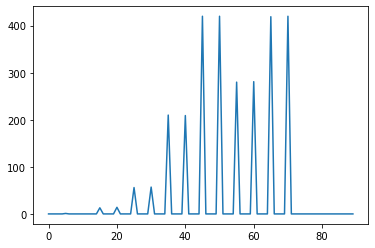

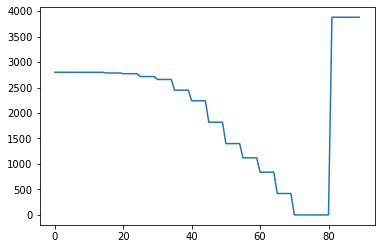

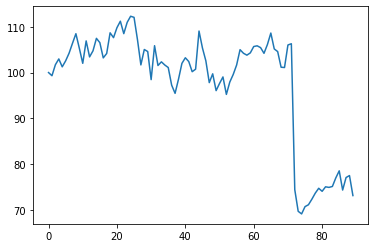

283688.4711879425


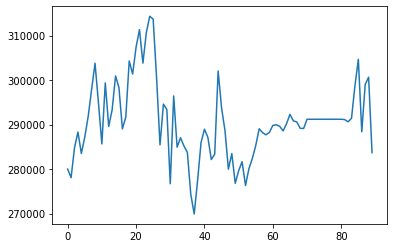

In [54]:
q = multiprocessing.Queue(maxsize = max_worker)
r = get_window_score(q,best_parameters, total_data_index, plot_graphs = True)
#r = get_window_score(q,best_parameters, (2000, 6000), CAPITAL, True)

print(q.get()[0])